In [522]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
# deep learning
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy

In [523]:
monk1_train = pd.read_csv('data/monks-1.train',header=None,sep=" ")
monk1_test = pd.read_csv('data/monks-1.test',header=None,sep=" ")

In [524]:
monk1_train.drop(0,axis=1,inplace=True)
monk1_train.drop(8,axis=1,inplace=True)

monk1_test.drop(0,axis=1,inplace=True)
monk1_test.drop(8,axis=1,inplace=True)

In [525]:
xtr = monk1_train.iloc[:,1:]
ytr = monk1_train.iloc[:,0]

xts = monk1_test.iloc[:,1:]
yts = monk1_test.iloc[:,0]

In [526]:
scaler = StandardScaler()
xtr = scaler.fit_transform(xtr)
xts = scaler.fit_transform(xts)

In [527]:
'''
When splitting for model selection (training and validation), uknown error
'''

#xtr, xvl, ytr, yvl = train_test_split(xtr, ytr, test_size=0.20, random_state=42)

In [528]:
class ClassificationMonk(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden1, learning_rate):
        super(ClassificationMonk, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        # Second hidden layer
        self.linear2 = nn.Linear(hidden1, hidden1)
        self.act2 = nn.ReLU()
        # Third hidden layer
        self.linear3 = nn.Linear(hidden1,output_dim)
        self.act3 = nn.Sigmoid()
        self.loss_fun = nn.MSELoss()
        self.learning_rate = learning_rate
    
    def forward(self, X):
        #Input to the first hidden layer
        X = self.linear1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.linear2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.linear3(X)
        X = self.act3(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch  #1
        X = X.type(torch.float32)
        y = y.type(torch.float32)  #2
        # forward pass
        y_pred = self.forward(X).squeeze()  #3 
        # compute loss
        loss = self.loss_fun(y_pred, y)  #4
        self.log_dict({'train_loss': loss}, on_step=False, on_epoch=True, prog_bar=True, logger=True)  
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        #y = y.type(torch.float32)
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics       
        print(y_pred) 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred[0], y[0])
        self.log_dict({'test_loss': loss, 'accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        #y = y.type(torch.float32)
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics       
        print(y_pred) 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred[0], y[0])
        self.log_dict({'test_loss': loss, 'accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [529]:
hidden1 = 20  
max_epochs = 500  
lr = 0.01
train_batch_size = 20  
validation_batch_size = 20  
test_batch_size = 20 

In [530]:
# model instance
input_dim = xtr.shape[1]
model = ClassificationMonk(input_dim=input_dim, output_dim=1, hidden1=hidden1, learning_rate=lr)

In [531]:
class ClassificationMonkDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [532]:
train_loader = DataLoader(dataset = ClassificationMonkDataset(xtr, ytr), batch_size=train_batch_size)
validation_loader = DataLoader(dataset = ClassificationMonkDataset(xvl, yvl), batch_size=validation_batch_size)
test_loader = DataLoader(dataset = ClassificationMonkDataset(xts, yts), batch_size=test_batch_size)

In [533]:
# early stopping
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.0001, patience=10, verbose=True, mode="min")

In [534]:
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs, callbacks=[early_stop_callback], log_every_n_steps=8)  
#trainer.tune(model=model, train_dataloaders=train_loader) #for auto_lr_finder
trainer.fit(model=model, train_dataloaders=train_loader)  

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name     | Type    | Params
-------------------------------------
0 | linear1  | Linear  | 140   
1 | act1     | ReLU    | 0     
2 | linear2  | Linear  | 420   
3 | act2     | ReLU    | 0     
4 | linear3  | Linear  | 21    
5 | act3     | Sigmoid | 0     
6 | loss_fun | MSELoss | 0     
-------------------------------------
581       Trainable params
0         Non-trainable params
581       Total params
0.002     Total estimated model params size (MB)
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: Possible

Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.257
Metric train_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.231
Metric train_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.217
Metric train_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.202
Metric train_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.182
Metric train_loss improved by 0.024 >= min_delta = 0.0001. New best score: 0.159
Metric train_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.140
Metric train_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.128
Metric train_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.119
Metric train_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.108
Metric train_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.097
Metric train_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.087
Metric train_loss improved by 0.009 >= min_delta = 0.0001. 

In [535]:
'''
best lr and plot aren't equal, why?
'''

lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

/var/folders/tz/9k5bcs_502z2svd2fr_k2w680000gn/T/ipykernel_1263/1529364680.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


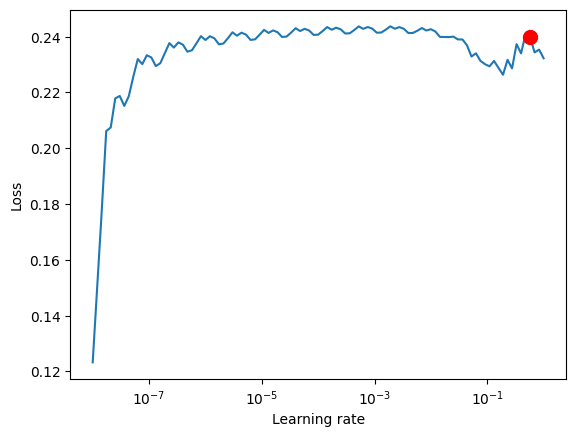

In [536]:
# why not 10^-8 ?

fig = lr_finder.plot(suggest=True)
fig.show()

In [537]:
# no good estimation of model, just testing
trainer.test(model=model, dataloaders=test_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

tensor([1.0000, 1.0000, 0.9998, 0.9976, 0.7507, 0.9794, 0.6594, 0.9906, 1.0000,
        1.0000, 0.9996, 0.9967, 0.5341, 0.9456, 0.3902, 0.9752, 1.0000, 1.0000,
        0.9993, 0.9910])
tensor([0.4548, 0.9202, 0.1856, 0.9214, 1.0000, 0.9999, 1.0000, 0.9910, 0.9848,
        0.8790, 0.9940, 0.9748, 1.0000, 1.0000, 1.0000, 0.9752, 0.9863, 0.7668,
        0.9833, 0.9474])
tensor([1.0000e+00, 9.9998e-01, 9.9995e-01, 9.3143e-01, 9.9187e-01, 7.1524e-01,
        9.6791e-01, 8.6138e-01, 9.9943e-01, 9.9994e-01, 4.9244e-03, 4.3573e-02,
        3.4776e-04, 5.4166e-03, 1.5744e-04, 2.8048e-03, 9.9961e-01, 9.9998e-01,
        4.6036e-03, 6.9848e-02])
tensor([2.2714e-04, 2.9460e-03, 9.7159e-05, 1.9265e-03, 9.9989e-01, 9.9998e-01,
        3.3152e-03, 9.0606e-02, 1.1925e-04, 1.0753e-03, 5.6578e-05, 1.0847e-03,
        9.9945e-01, 9.8973e-01, 5.2019e-01, 8.8940e-03, 4.7840e-03, 8.7433e-03,
        3.3197e-03, 1.6549e-02])
tensor([9.9982e-01, 9.9803e-01, 4.6256e-01, 5.7961e-03, 2.3773e-03, 4.3766e-03,
    

[{'test_loss': 0.034726258367300034, 'accuracy': 0.9189814925193787}]